In [1]:
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import json, codecs
%matplotlib inline

In [2]:
#определяем начальные значения
data = {"gamma_w": 1.14, "h":1680, "d_in":110, "q_liq":902, "eps":2.3E-5, "p_wh": 25.1, "MD": [0, 840.00, 1680], "TVD": [0, 785.00, 1350.00], "T0": 21.2}

gamma_w = data['gamma_w']
h = data['h']
d_in = data['d_in']* 10**(-3)
Q = data['q_liq']
eps = data['eps']
p_wh = data['p_wh']
MD = np.array([0, 840.00, 1680])
TVD = np.array([0, 785.00, 1350.00])
T0 = data['T0']
g = 9.8


In [3]:
#считаем, что соленость воды = 0 (формулы из лекции)

#число Рейнольдса
def Rey(q, ro = 1000, visc = 0.2, d = d_in):
    v = (4*q/86400)/(np.pi * d**2)
    return (ro * v * d)/visc * 1000


#плотность воды зависит только от температуры
def ro(T):
    ro_w = 1000*gamma_w
    ro = ro_w/(1+(T - 273)/10000*(0.269*(T - 273)**(0.673) - 0.8))
    return ro


#вязкость пресной воды (Метью и Руссель)    
def visc(P, T):
    A = 109.574
    B = 1.1217
    visc = A * (1.8 * T - 460) ** (-B) * (0.9994 + 0.0058 * P + 0.6534 * 10**(-4) * P ** 2)
    return visc
    
 
#коэффициент трения воды по Черчиллю
def fric_ch(q, d = d_in,mu = 0.2,ro = 1000, cos_alpha=1, eps = eps):
    Re = Rey(q, ro, mu, d)
    A = (-2.457 * np.log((7/Re)**(0.9) + 0.27*(eps/d)))**16
    B = (37530/Re)**16
    return 8*((8/Re)**12 + 1/(A+B)**1.5)**(1/12)


In [4]:
#градиент давления
def Pgrad(q, P, T, d = d_in, cos_alpha = 1, eps = eps):
    ro1 = ro(T + 273)
    visc1 = visc(P, T + 273)
    f = fric_ch(q, d, visc1, ro1, eps = eps)
    v = (q/86400)/(np.pi * d**2/4)
    return (ro1 * g * cos_alpha - f * ro1 * v**2 / (2*d)) / 10**6

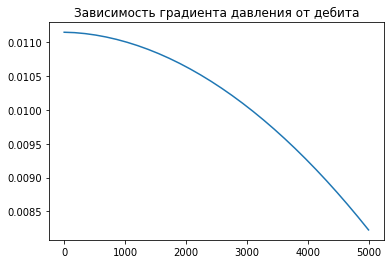

In [9]:
x = np.linspace(1, 5000, 30)
plt.plot(x, [Pgrad(t,20,20) for t in x])
plt.title('Зависимость градиента давления от дебита')
plt.show()

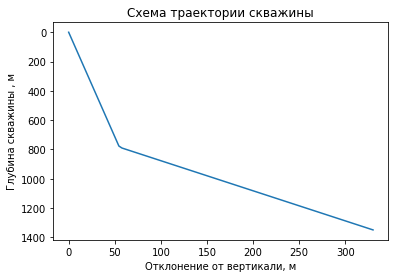

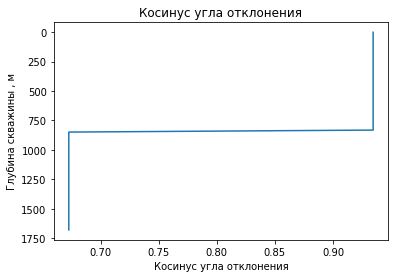

In [10]:

#удлиннение скважины
Udl = interp1d(MD, MD-TVD, kind = 'linear')
Hv = interp1d(MD,TVD, kind='linear', fill_value="extrapolate")

def cos_alpha(h, H_vert = Hv, dh = 0.5): # h - координата вдоль скважины (MD)
    return (H_vert(h+dh)-H_vert(h))/dh


h_ = np.linspace(0, h, num=100, endpoint=True)
plt.plot(Udl(h_), Hv(h_), '-')
plt.xlabel("Отклонение от вертикали, м")
plt.ylabel("Глубина скважины , м")
plt.title("Схема траектории скважины")
ax = plt.gca()
ax.invert_yaxis()
plt.show()
plt.plot(cos_alpha(h_), (h_), '-')
plt.xlabel("Косинус угла отклонения")
plt.ylabel("Глубина скважины , м")
plt.title("Косинус угла отклонения")
ax = plt.gca()
ax.invert_yaxis()
plt.show()


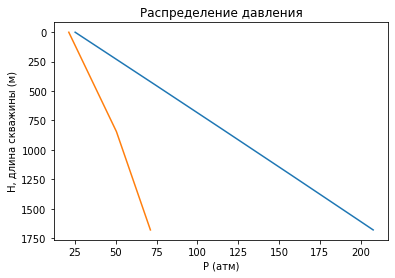

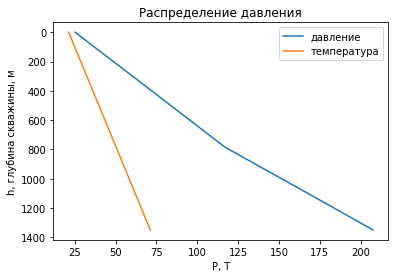

In [11]:
grad_T = 50/np.max(TVD)

def grad_PT(PT, H):
    dPdx = Pgrad(Q, PT[0], PT[1], cos_alpha(H))
    dTdx = grad_T * cos_alpha(H)
    return [dPdx, dTdx]

# Граничные условия
p_wh = data["p_wh"] * 0.101325 # атмосферы в МПа
PTwh = [p_wh, T0]
#диапазон интегрирования
_h_ = np.linspace(0, h, 200)
solution = odeint(grad_PT, PTwh, _h_)
#результаты
P = solution[:,0]/0.101325  
T = solution[:,1]  


#распределение давления
plt.plot(P,_h_, label ="давление")
plt.plot(T,_h_, label ="температура")
plt.xlabel("P (атм)")
plt.ylabel("H, длина скважины (м)")
ax = plt.gca()
ax.invert_yaxis()
plt.title("Распределение давления")
plt.show()

plt.plot(P,Hv(_h_), label ="давление")
plt.plot(T,Hv(_h_), label = "температура")
plt.xlabel("P, Т")
plt.ylabel("h, глубина скважины, м")
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.title("Распределение давления");

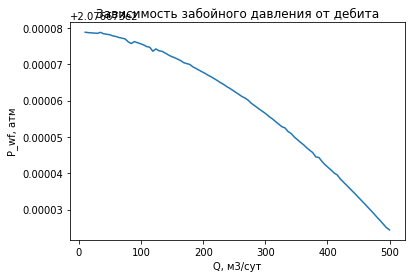

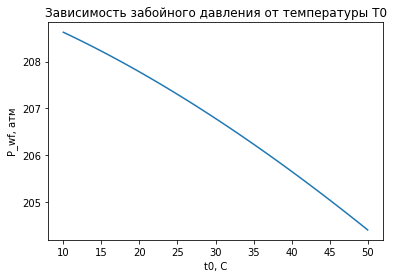

In [12]:

# Зависимость от дебита (от 10 до 500 м3/сут)
QQ = np.linspace(10, 500, 100)
P_wf = []

for q in QQ:
    def grad_PT(PT, _h_):
        dPdx = Pgrad(q, PT[0], PT[1], cos_alpha(_h_))
        dTdx = grad_T * cos_alpha(_h_)
        return [dPdx, dTdx]
    solution = odeint(grad_PT, PTwh, _h_)
    p_ = solution[:,0]
    P_wf.append(p_[len(_h_)-1]/0.101325) #МПа->атм

plt.title("Зависимость давления от дебита")
plt.plot(QQ, P_wf)
plt.xlabel("Q, м3/сут")
plt.ylabel("P_wf, атм")
plt.show()

# Зависимость от температуры T0(от 10 до 50 Цельсия)
t0 = np.linspace(10, 50, 100)
P_wf_T = []

for twh in t0:
    def grad_PT(PT, _h_):
        dPdx = Pgrad(q, PT[0], PT[1], cos_alpha(_h_))
        dTdx = grad_T * cos_alpha(_h_)
        return [dPdx, dTdx]
    Ptwh = [p_wh, twh]
    solution = odeint(grad_PT, Ptwh, _h_)
    p_ = solution[:, 0]
    P_wf_T.append(p_[len(_h_) - 1] / 0.101325)  # МПа->атм

plt.title("Зависимость давления от температуры T0")
plt.plot(t0, P_wf_T)
plt.xlabel("t0, С")
plt.ylabel("P_wf, атм")
plt.show()


#Запись результата в файл
result = {"ex1": {"h": list(_h_[:]), "p_wf": list(P[:])},
          "ex2": {"q_liq": list(QQ[:]), "p_wf": list(P_wf[:])},
          "ex3": {"t": list(t0[:]),  "p_wf": list(P_wf_T[:])}
          }
with open('result.json', 'wb') as f:
    json.dump(result, codecs.getwriter('utf-8')(f), ensure_ascii=False)